#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
#!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
To: /home/jupyter/week 5/IT_data.h5
100%|██████████| 384M/384M [00:07<00:00, 48.6MB/s] 


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


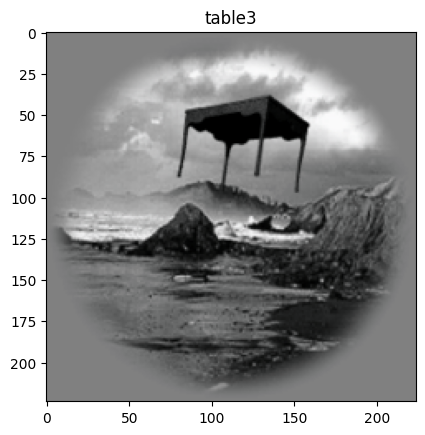

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

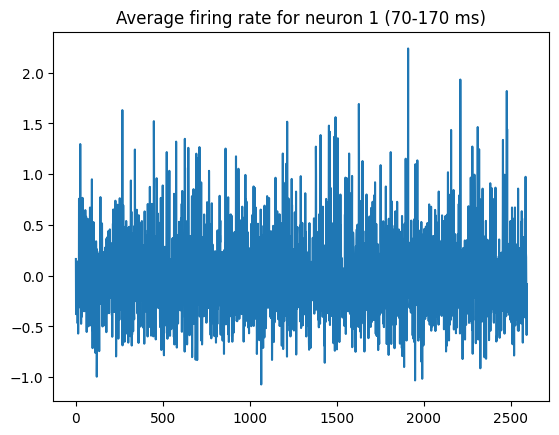

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

## 0: Packtage and setup

In [7]:
#import packtage

import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from math import *
from sklearn import metrics as ms
from sklearn.decomposition import PCA, IncrementalPCA

In [8]:
from sklearn import linear_model
from scipy.stats import pearsonr

In [35]:
#choose the model
model = torchvision.models.resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
#model = torchvision.models.resnet50(weights=None)

In [10]:
#do the batch
dataloader_train = DataLoader(torch.Tensor(stimulus_train), batch_size = 64)
dataloader_valid = DataLoader(torch.Tensor(stimulus_val), batch_size = 64)

In [36]:
#environnement
Name = ['conv1','layer1','layer2','layer3','layer4','avgpool']
model_layer = {'conv1':model.conv1,'layer1':model.layer1,'layer2':model.layer2,'layer3':model.layer3,'layer4':model.layer4,'avgpool':model.avgpool}

correlation = {'conv1':[],'layer1':[],'layer2':[],'layer3':[],'layer4':[],'avgpool':[]}
variance = {'conv1':[],'layer1':[],'layer2':[],'layer3':[],'layer4':[],'avgpool':[]}
mCorr = {'conv1':[],'layer1':[],'layer2':[],'layer3':[],'layer4':[],'avgpool':[]}
mVar = {'conv1':[],'layer1':[],'layer2':[],'layer3':[],'layer4':[],'avgpool':[]}
#mCorr_untrain = {'conv1':[],'layer1':[],'layer2':[],'layer3':[],'layer4':[],'avgpool':[]}
#mVar_untrain = {'conv1':[],'layer1':[],'layer2':[],'layer3':[],'layer4':[],'avgpool':[]}

In [12]:
stimulus_train.shape

(2592, 3, 224, 224)

In [13]:
stimulus_val.shape

(288, 3, 224, 224)

## 1 : function to apply the model

In [14]:
features = []
#function to hook the features
def get_features():
    def hook(model, input, output):
        features.append(output.detach())
    return hook

In [15]:
#function that get the PCs from a layer (with the training set)
def get_layer(name) :
    hooked =model_layer[name].register_forward_hook(get_features())
    
    for batch in dataloader_train:
        pred_res = model(torch.Tensor(batch))
    
    hooked.remove()
    
    output = torch.concat(features,axis=0).detach().numpy()
    pca.fit(output.reshape(output.shape[0],-1))
    
    return pca.transform(output.reshape(output.shape[0],-1))

In [16]:
#fonction that get the PCs from a layer (with the validation dataset)
def get_validation(name) :
    hooked =model_layer[name].register_forward_hook(get_features())
    
    for batch in dataloader_valid:
        pred_res = model(torch.Tensor(batch))
    
    hooked.remove()

    output = torch.concat(features,axis=0).detach().numpy()
    
    return pca.transform(output.reshape(output.shape[0],-1))

## 2 : function for model evaluation

In [17]:
#value is the expected neural activity and prediction is the predicted one
#this function plot some neural activities and compute the correlation and explained variance 
#display the mean of correlation and explained variance and return two array

def evaluation(value, prediction, title) :
    
    #plot neural activities
    plt.figure()
    
    N = 5
    fig, axs = plt.subplots(N, 1)

    for n in range(N) : 
        axs[n].plot(value[:,n])
        axs[n].plot(prediction[:,n])

    plt.show()
    plt.savefig('figure/bunch of prediction vs recording neural activity '+ title)

    #compute correlation and explained variance
    correlation = []
    var = []

    for i in range(value.shape[1]) : #each neuron
        correlation.append(pearsonr(value[:,i],prediction[:,i])[0])
        var.append(ms.explained_variance_score(value[:,i],prediction[:,i]))
    
    #plot correlation and explained variance
    plt.figure()
    plt.title('explained variance for each neuron '+ title)
    plt.xlabel('neurons')
    plt.ylabel("explained variance")
    plt.plot(var)
    plt.savefig('figure/explained variance for each neuron '+ title)
    plt.show()
    
    plt.figure()
    plt.title('correlation for each neuron '+ title)
    plt.xlabel('neurons')
    plt.ylabel("correlation")
    plt.plot(correlation)
    plt.savefig('figure/correlation for each neuron '+ title)
    plt.show()
    
    mCorr =np.mean(correlation)
    mVar =np.mean(var)
    #print the means
    print('mean of correlation ', mCorr)
    print('mean of explained variance ',mVar)
    
    #return arrays
    return correlation,var,mCorr,mVar

## 3 : model of part 1

In [18]:
LinearModel = linear_model.Ridge()
#we chose the normal model with redge because the optimal value was too high for alpha. This model will have alpha = 10

## 4 : Predict neural activity layer by layer

On layer conv1
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

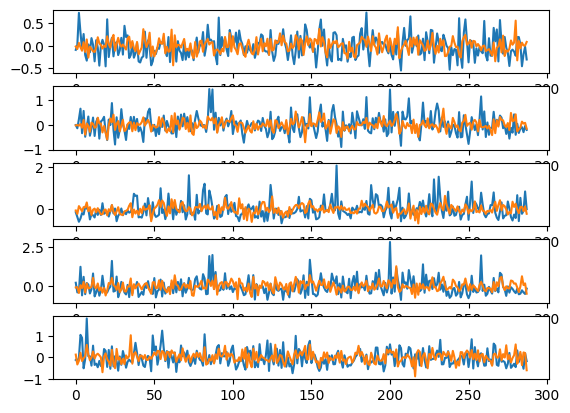

<Figure size 640x480 with 0 Axes>

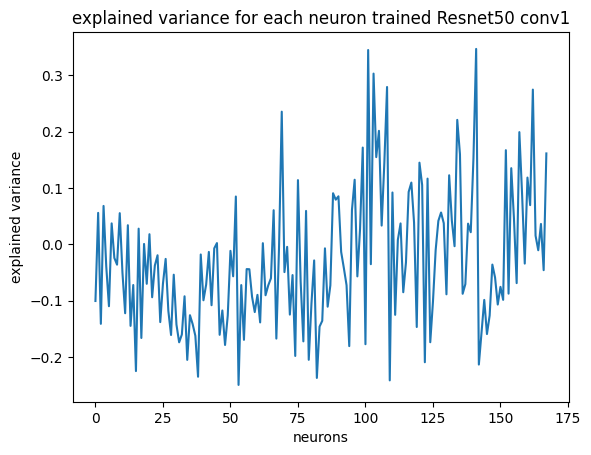

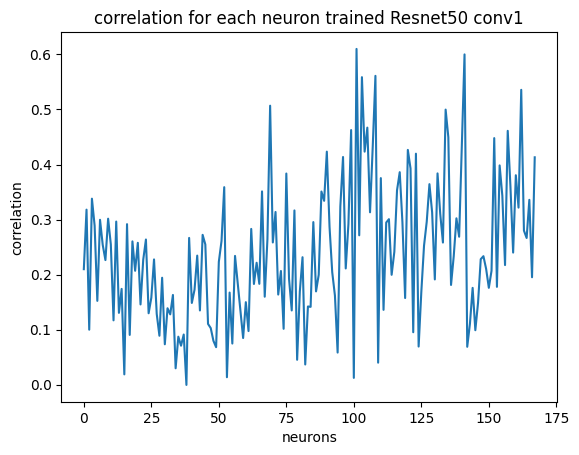

mean of correlation  0.2400179308388368
mean of explained variance  -0.027579789360364277
On layer layer1
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

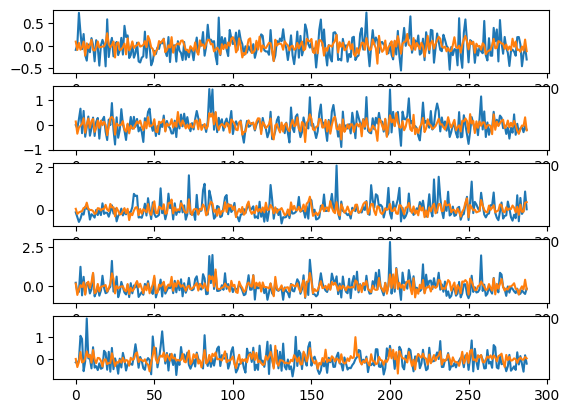

<Figure size 640x480 with 0 Axes>

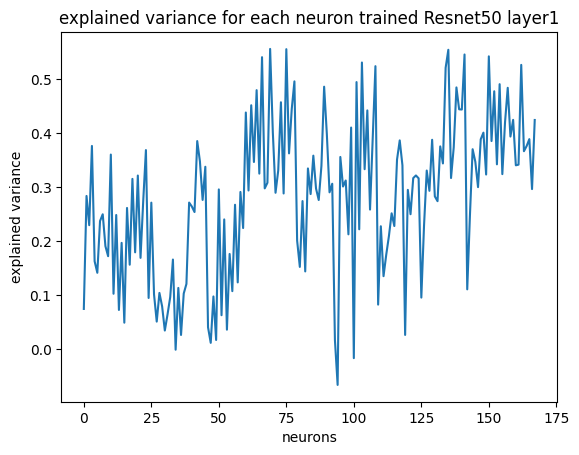

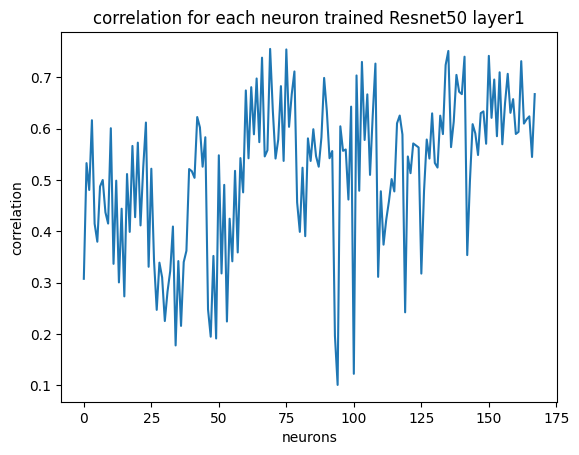

mean of correlation  0.5174418882587645
mean of explained variance  0.28199477103494464
On layer layer2
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

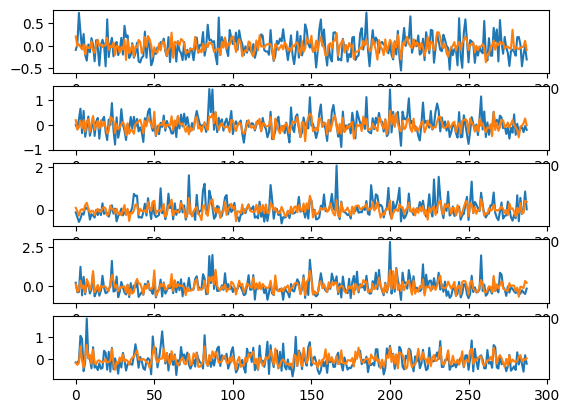

<Figure size 640x480 with 0 Axes>

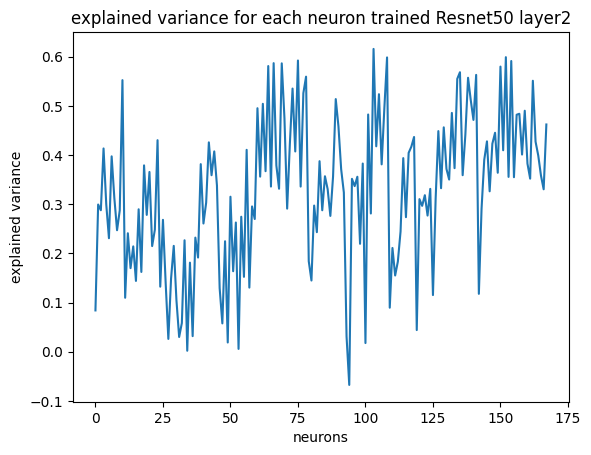

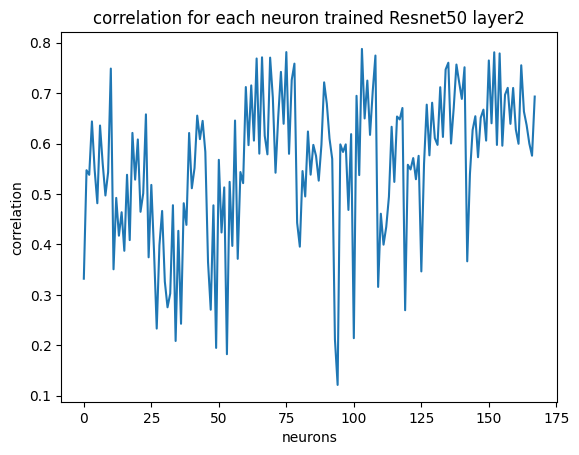

mean of correlation  0.5596221842992275
mean of explained variance  0.32679920004946844
On layer layer3
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

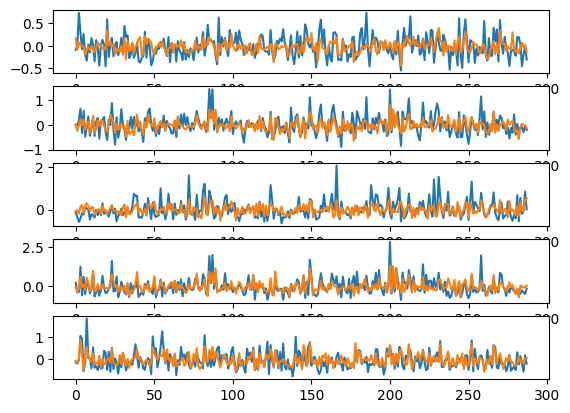

<Figure size 640x480 with 0 Axes>

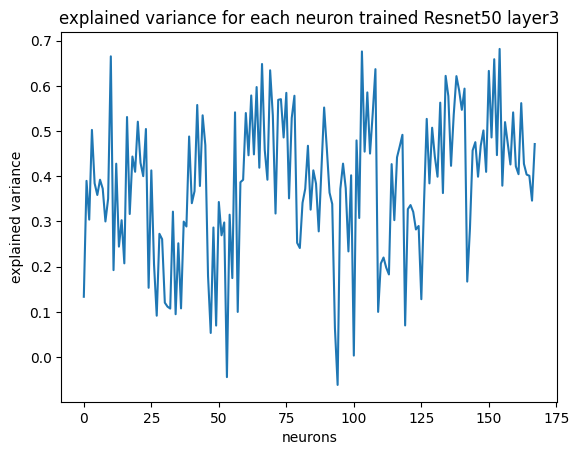

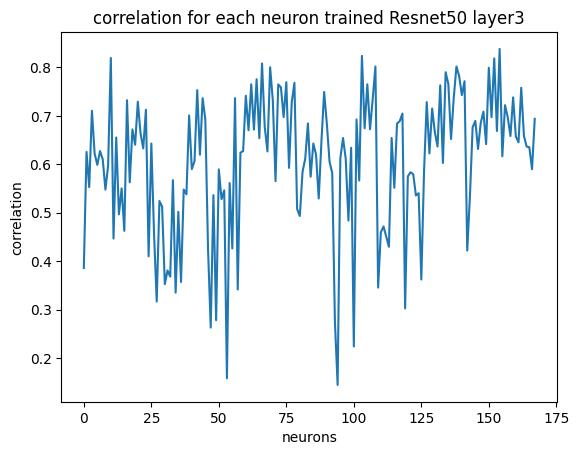

mean of correlation  0.6075443307753223
mean of explained variance  0.3821855471247718
On layer layer4
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

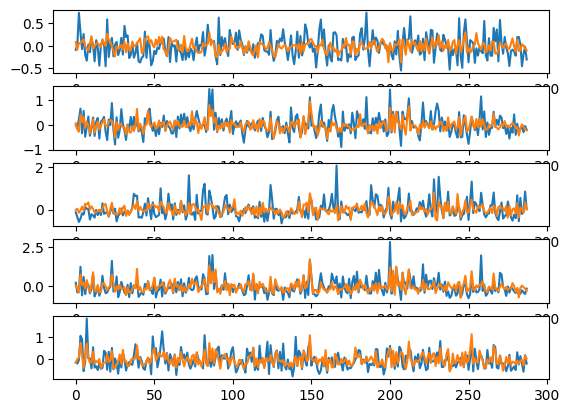

<Figure size 640x480 with 0 Axes>

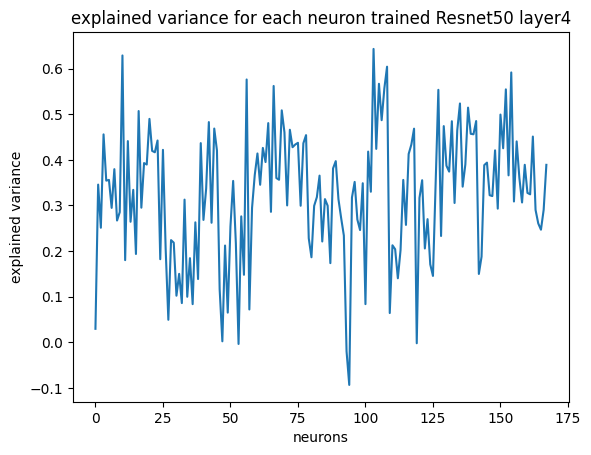

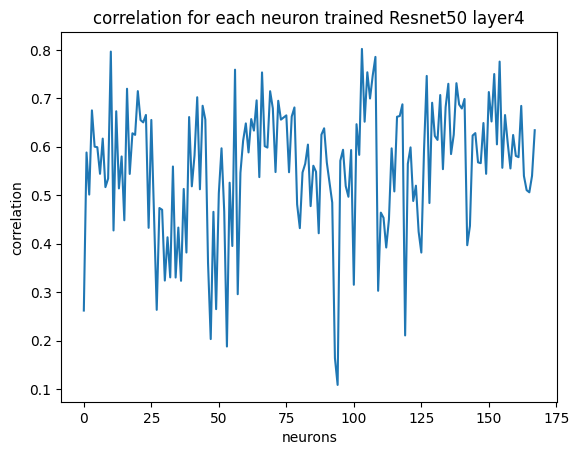

mean of correlation  0.5592848247841705
mean of explained variance  0.3241231051229295
On layer avgpool
Done 1000 PCs for each layer activation
Done 1000 PCs for prediction


<Figure size 640x480 with 0 Axes>

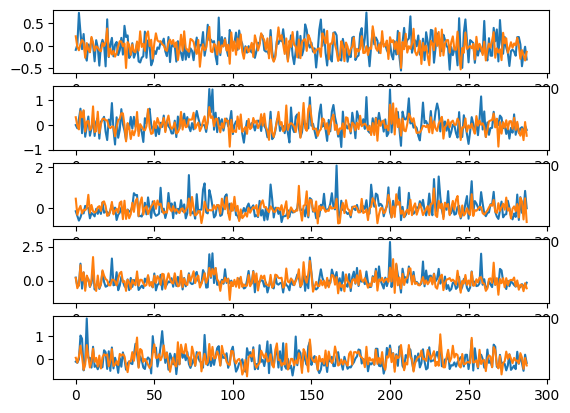

<Figure size 640x480 with 0 Axes>

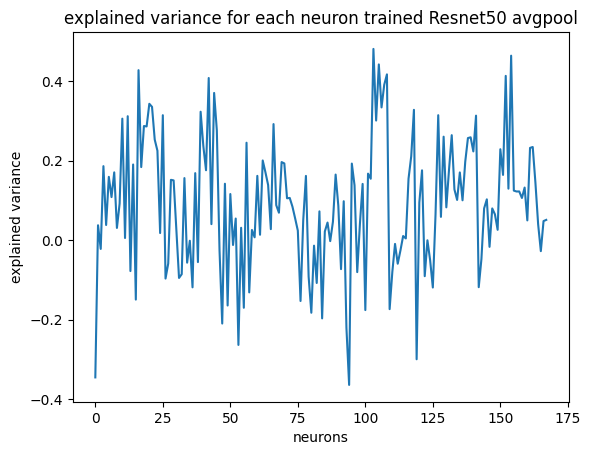

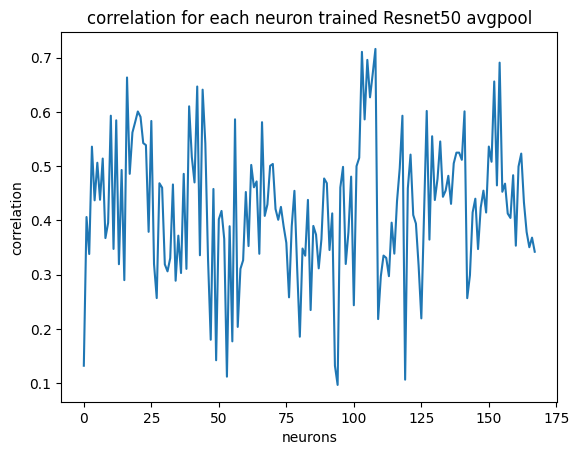

mean of correlation  0.4238338085710912
mean of explained variance  0.0921940470025653


In [37]:
#layer by layer :
#take activation on training dataset
#compute PCs and fit the pca
#take activation on validation dataset
#apply PCA
#
for layer in Name :
    print("On layer "+layer)
    
    pca = PCA(n_components=1000)
    features = []
    PC_activation = get_layer(layer)
    print("Done 1000 PCs for each layer activation")
    
    features = []
    PC_activation_validation = get_validation(layer)
    print("Done 1000 PCs for prediction")
    
    LinearModel.fit(PC_activation,spikes_train)
    y_pred = LinearModel.predict(PC_activation_validation)
    correlation[layer],variance[layer],mCorr[layer],mVar[layer] = evaluation(spikes_val, y_pred, "trained Resnet50 "+layer)

## 5 : Plot correlation and explained variance regarding the layer

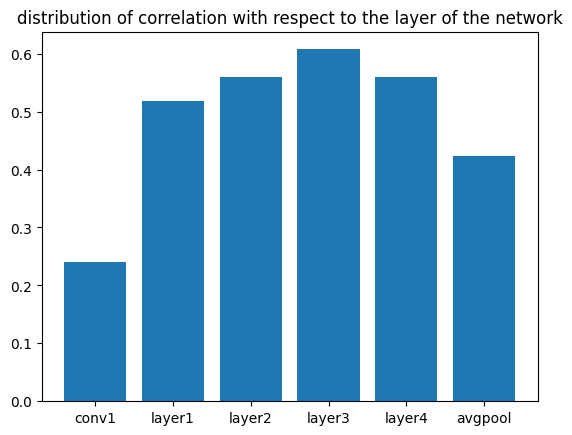

<Figure size 640x480 with 0 Axes>

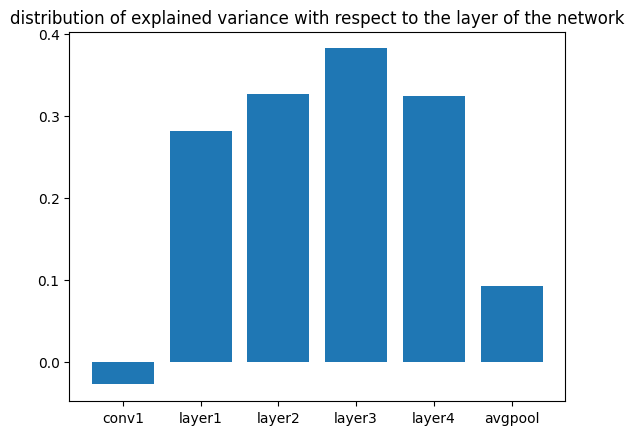

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure()
plt.bar(mCorr.keys(), mCorr.values())
plt.title("distribution of correlation with respect to the layer of the network")
plt.show()
plt.savefig('figure/correlation_untrain')

plt.figure()
plt.bar(mVar.keys(), mVar.values())
plt.title("distribution of explained variance with respect to the layer of the network")
plt.show()
plt.savefig('figure/variance_untrain')

## 6 : Compare models

We already run the code on both the random and the trained ResNet50. All the figure are in "figure", if you want to change the model change the loaded one at the beggining of this file.

In [42]:
mVar = {'conv1': -0.027579789360364277,
 'layer1': 0.28199477103494464,
 'layer2': 0.32679920004946844,
 'layer3': 0.3821855471247718,
 'layer4': 0.3241231051229295,
 'avgpool': 0.0921940470025653}

In [43]:
mCorr = {'conv1': 0.2400179308388368,
 'layer1': 0.5174418882587645,
 'layer2': 0.5596221842992275,
 'layer3': 0.6075443307753223,
 'layer4': 0.5592848247841705,
 'avgpool': 0.4238338085710912}

In [44]:
mCorr_untrain = {'conv1': 0.21529533344659701,
 'layer1': 0.4459433668314371,
 'layer2': 0.42265494566934597,
 'layer3': 0.3413459334826639,
 'layer4': 0.2744751576767746,
 'avgpool': 0.13474437431444689
}

In [45]:
mVar_untrain = {'conv1': -0.08944916228453319,
 'layer1': 0.2035912839429719,
 'layer2': 0.1898009872862271,
 'layer3': 0.12429449068648475,
 'layer4': 0.07523425668478012,
 'avgpool': -0.25844999509198324}

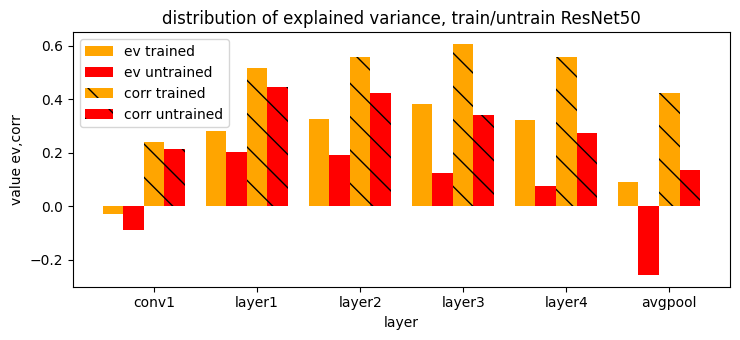

In [68]:
plt.figure()

X_axis = np.arange(len(Name))

plt.bar(X_axis-0.4, mVar.values(),0.2,color = 'orange',label = 'ev trained')
plt.bar(X_axis-0.2, mVar_untrain.values(),0.2,color = 'red',label = 'ev untrained')
bars = plt.bar(X_axis, mCorr.values(),0.2,color = 'orange',label = 'corr trained') + plt.bar(X_axis+0.2, mCorr_untrain.values(),0.2,color = 'red',label = 'corr untrained')

patterns = ('\\')
for bar in bars :
    bar.set_hatch(pattern)

plt.xticks(X_axis, Name)

plt.xlabel("layer")
plt.ylabel("value ev,corr")
plt.title("distribution of explained variance, train/untrain ResNet50")
plt.legend()
plt.savefig('figure/variance report')
plt.show()